In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from typing import List, Set, Tuple
import random
from functools import partial
import json
from datetime import datetime
import os
from mpi4py import MPI
from scipy.linalg import eigh

class DeepNN(nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'special', gamma: float = 1.0):
        super().__init__()
        self.gamma = gamma
        # ... rest of initialization code stays the same ...

        
        torch.set_default_dtype(torch.float32)
        
        self.mode = mode
        self.depth = depth
        self.hidden_size = hidden_size
        self.input_dim = d
        
        layers = []
        prev_dim = d
        self.layer_lrs = []  # Store layerwise learning rates
        
        for layer_idx in range(depth):
            linear = nn.Linear(prev_dim, hidden_size)
            
            if mode == 'special':
                # Special initialization as in original code
                gain = nn.init.calculate_gain('relu')
                std = gain / np.sqrt(prev_dim)
                nn.init.normal_(linear.weight, mean=0.0, std=std)
                nn.init.zeros_(linear.bias)
                self.layer_lrs.append(1.0)
                
            elif mode == 'spectral':
                # Implement spectral initialization
                fan_in = prev_dim
                fan_out = hidden_size
                std = (1.0 / np.sqrt(fan_in)) * min(1.0, np.sqrt(fan_out / fan_in))
                nn.init.normal_(linear.weight, mean=0.0, std=std)
                nn.init.zeros_(linear.bias)
                self.layer_lrs.append(float(fan_out) / fan_in)
                
            elif mode == 'mup_pennington':
                # muP initialization and learning rates from the paper
                if layer_idx == 0:  # Embedding layer
                    std = 1.0 / np.sqrt(prev_dim)
                    lr_scale = 1.0  # O(1) learning rate for embedding
                else:  # Hidden layers
                    std = 1.0 / np.sqrt(prev_dim)
                    lr_scale = 1.0 / prev_dim  # O(1/n) learning rate for hidden
                nn.init.normal_(linear.weight, mean=0.0, std=std)
                nn.init.zeros_(linear.bias)
                self.layer_lrs.append(lr_scale)
                
            else:  # standard
                nn.init.xavier_uniform_(linear.weight)
                nn.init.zeros_(linear.bias)
                self.layer_lrs.append(1.0)
            
            layers.extend([
                linear,
                nn.ReLU()
            ])
            prev_dim = hidden_size
        
        # Final layer
        final_layer = nn.Linear(prev_dim, 1)
        if mode == 'special':
            nn.init.normal_(final_layer.weight, std=0.01)
            self.layer_lrs.append(1.0)
        elif mode == 'spectral':
            fan_in = prev_dim
            fan_out = 1
            std = (1.0 / np.sqrt(fan_in)) * min(1.0, np.sqrt(fan_out / fan_in))
            nn.init.normal_(final_layer.weight, std=std)
            self.layer_lrs.append(float(fan_out) / fan_in)
        elif mode == 'mup_pennington':
            std = 1.0 / np.sqrt(prev_dim)
            lr_scale = 1.0 / prev_dim  # O(1/n) learning rate for readout
            nn.init.normal_(final_layer.weight, std=std)
            self.layer_lrs.append(lr_scale)
        else:
            nn.init.xavier_uniform_(final_layer.weight)
            self.layer_lrs.append(1.0)
            
        nn.init.zeros_(final_layer.bias)
        layers.append(final_layer)
        
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        gamma = float(self.gamma)  # Ensure gamma is a float
        return self.network(x).squeeze() / gamma
    
    def get_layer_learning_rates(self, base_lr: float) -> List[float]:
        """Return list of learning rates for each layer"""
        return [base_lr * lr for lr in self.layer_lrs]

In [5]:
import torch
import torch.nn as nn
import numpy as np
import os
import json
from typing import List, Dict, Tuple, Optional
from torch.distributions import Normal, kl_divergence, Laplace, StudentT
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from pathlib import Path

class PriorDistribution:
    """Different choices of prior distributions"""
    @staticmethod
    def get_prior(name: str, latent_dim: int, device: torch.device):
        if name == "normal":
            return Normal(torch.zeros(latent_dim).to(device), torch.ones(latent_dim).to(device))
        elif name == "laplace":
            return Laplace(torch.zeros(latent_dim).to(device), torch.ones(latent_dim).to(device))
        elif name == "student":
            # Student's t with 5 degrees of freedom
            return StudentT(5, torch.zeros(latent_dim).to(device), torch.ones(latent_dim).to(device))
        else:
            raise ValueError(f"Unknown prior: {name}")

class RateDistortionEncoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int, prior: str = "normal"):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.prior_name = prior
        
        # More sophisticated encoder architecture
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 2*input_dim),
            nn.LayerNorm(2*input_dim),
            nn.ReLU(),
            nn.Linear(2*input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, 2 * latent_dim)  # mu and logvar
        )
        
        # More sophisticated decoder architecture
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, input_dim),
            nn.LayerNorm(input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, 2*input_dim),
            nn.ReLU(),
            nn.Linear(2*input_dim, input_dim)
        )
    
    def encode(self, x: torch.Tensor) -> tuple:
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar
    
    def decode(self, z: torch.Tensor) -> torch.Tensor:
        return self.decoder(z)
    
    def forward(self, x: torch.Tensor, beta: float) -> tuple:
        mu, logvar = self.encode(x)
        std = torch.exp(0.5 * logvar)
        
        # Get prior
        prior = PriorDistribution.get_prior(self.prior_name, self.latent_dim, x.device)
        
        # Sample using reparameterization trick
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        # Decode
        recon = self.decode(z)
        
        # Compute KL divergence based on prior
        if self.prior_name == "normal":
            rate = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
        else:
            q_z = Normal(mu, std)
            rate = kl_divergence(q_z, prior).sum(dim=1).mean()
        
        # Compute distortion
        distortion = torch.mean((recon - x).pow(2))
        
        loss = rate + beta * distortion
        return loss, rate.item(), distortion.item()

def verify_dataset_match(data_path: str, n_train: int, rank: int) -> bool:
    """Verify that dataset matches expected parameters"""
    try:
        data_dict = torch.load(data_path)
        return (data_dict['shape_X'][0] == n_train and 
                data_dict['saved_by_rank'] == rank)
    except:
        return False

def load_model_and_data(model_path: str, data_path: str, n_train: int, rank: int,
                       d: int, hidden_size: int, depth: int, mode: str, gamma: float) -> Tuple[nn.Module, torch.Tensor]:
    """Load model and corresponding dataset with verification"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Verify paths exist
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model not found: {model_path}")
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Dataset not found: {data_path}")
    
    # Verify dataset matches parameters
    if not verify_dataset_match(data_path, n_train, rank):
        raise ValueError(f"Dataset mismatch for {data_path}")
    
    # Load model
    model = DeepNN(d, hidden_size, depth, mode=mode, gamma=gamma).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Load dataset
    data_dict = torch.load(data_path)
    X = data_dict['X'].to(device)
    
    return model, X

def plot_rd_curves(results: Dict, save_dir: str):
    """Plot Rate-Distortion curves with comparisons"""
    # Create save directory
    save_dir = Path(save_dir) / "rd_plots"
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Set style
    plt.style.use('seaborn')
    
    # Group results by model configuration
    configs = {}
    for result in results:
        config = (
            result['model_config']['hidden_size'],
            result['model_config']['depth'],
            result['model_config']['n_train']
        )
        if config not in configs:
            configs[config] = []
        configs[config].append(result)
    
    # Plot for each configuration
    for (hidden_size, depth, n_train), model_results in configs.items():
        # Plot R(D) curves for each layer
        fig, ax = plt.subplots(figsize=(10, 6))
        
        for result in model_results:
            for layer_data in result['layer_results']:
                rd_points = layer_data['rd_points']
                rates = [p['rate'] for p in rd_points]
                distortions = [p['distortion'] for p in rd_points]
                
                ax.scatter(distortions, rates, alpha=0.5, 
                          label=f"Layer {layer_data['layer_idx']+1}")
                
                # Fit and plot curve
                try:
                    z = np.polyfit(distortions, rates, 2)
                    p = np.poly1d(z)
                    x_new = np.linspace(min(distortions), max(distortions), 100)
                    ax.plot(x_new, p(x_new), '--', alpha=0.5)
                except:
                    pass
        
        ax.set_xlabel('Distortion')
        ax.set_ylabel('Rate (bits)')
        ax.set_title(f'R(D) Curves (h={hidden_size}, d={depth}, n={n_train})')
        ax.legend()
        
        # Save plot
        plt.savefig(save_dir / f'rd_curve_h{hidden_size}_d{depth}_n{n_train}.png')
        plt.close()
    
    # Plot comparisons across training sizes
    for hidden_size in set(c[0] for c in configs):
        for depth in set(c[1] for c in configs):
            fig, ax = plt.subplots(figsize=(10, 6))
            
            for n_train in sorted(set(c[2] for c in configs)):
                config = (hidden_size, depth, n_train)
                if config not in configs:
                    continue
                
                # Average over layers
                rates = []
                distortions = []
                for result in configs[config]:
                    for layer_data in result['layer_results']:
                        rd_points = layer_data['rd_points']
                        rates.extend(p['rate'] for p in rd_points)
                        distortions.extend(p['distortion'] for p in rd_points)
                
                # Plot density
                xy = np.vstack([distortions, rates])
                z = gaussian_kde(xy)(xy)
                
                ax.scatter(distortions, rates, c=z, s=100, alpha=0.5,
                          label=f'n={n_train}')
            
            ax.set_xlabel('Distortion')
            ax.set_ylabel('Rate (bits)')
            ax.set_title(f'R(D) Comparison (h={hidden_size}, d={depth})')
            ax.legend()
            
            plt.savefig(save_dir / f'rd_comparison_h{hidden_size}_d{depth}.png')
            plt.close()


def compute_layer_activations(model: nn.Module, X: torch.Tensor) -> List[torch.Tensor]:
    """Get activations for each layer"""
    activations = []
    x = X
    
    with torch.no_grad():
        for layer in model.network[:-1]:  # Exclude final layer
            if isinstance(layer, nn.Linear):
                x = layer(x)
            elif isinstance(layer, nn.ReLU):
                x = layer(x)
                activations.append(x)
    
    return activations


def analyze_model_rd(model_path: str, data_path: str, n_train: int, rank: int,
                    d: int, hidden_size: int, depth: int, mode: str, gamma: float,
                    priors: List[str] = ["normal", "laplace", "student"]) -> Dict:
    """Analyze Rate-Distortion with multiple priors"""
    # Load model and data
    model, X = load_model_and_data(model_path, data_path, n_train, rank,
                                  d, hidden_size, depth, mode, gamma)
    
    # Get activations
    activations_list = compute_layer_activations(model, X)
    
    # Parameters for R(D) analysis
    latent_dims = [2, 4, 8, 16, 32]
    betas = [0.001, 0.01, 0.1, 1.0, 10.0]
    
    # Analyze each layer
    layer_results = []
    for layer_idx, activations in enumerate(activations_list):
        print(f"Analyzing layer {layer_idx+1}")
        
        layer_rd_points = []
        for prior in priors:
            rd_points = compute_rd_curve(activations, latent_dims, betas, prior=prior)
            for point in rd_points:
                point['prior'] = prior
            layer_rd_points.extend(rd_points)
        
        layer_results.append({
            'layer_idx': layer_idx,
            'rd_points': layer_rd_points,
            'activation_shape': list(activations.shape)
        })
    
    return {
        'model_path': model_path,
        'data_path': data_path,
        'model_config': {
            'd': d,
            'hidden_size': hidden_size,
            'depth': depth,
            'mode': mode,
            'gamma': gamma,
            'n_train': n_train
        },
        'layer_results': layer_results
    }

def compute_rd_curve(activations: torch.Tensor, latent_dims: List[int],
                    betas: List[float], prior: str = "normal",
                    epochs: int = 100) -> List[Dict]:
    """Compute rate-distortion curve with specified prior"""
    device = activations.device
    input_dim = activations.shape[1]
    rd_points = []
    
    for latent_dim in latent_dims:
        encoder = RateDistortionEncoder(input_dim, latent_dim, prior=prior).to(device)
        optimizer = torch.optim.Adam(encoder.parameters())
        
        for beta in betas:
            # Train VAE
            for epoch in range(epochs):
                optimizer.zero_grad()
                loss, rate, distortion = encoder(activations, beta)
                loss.backward()
                optimizer.step()
            
            # Record final values
            with torch.no_grad():
                _, rate, distortion = encoder(activations, beta)
                rd_points.append({
                    'latent_dim': latent_dim,
                    'beta': beta,
                    'rate': rate,
                    'distortion': distortion,
                    'prior': prior
                })
    
    return rd_points


def analyze_directory(results_dir: str, timestamp: str, 
                     filter_params: Dict[str, List] = None):
    """
    Analyze models with specified hyperparameters
    
    Args:
        results_dir: Directory containing results
        timestamp: Timestamp of experiment
        filter_params: Dict containing hyperparameters to filter by, e.g.,
            {
                'hidden_sizes': [400],
                'depths': [1],
                'n_train_sizes': [1000, 5000],
                'learning_rates': [0.005]
            }
    """
    # Load hyperparameters
    with open(os.path.join(results_dir, f'hyperparameters_{timestamp}.json'), 'r') as f:
        hyperparams = json.load(f)
    
    # Use filtered or full hyperparameters
    search_space = {
        'hidden_sizes': filter_params.get('hidden_sizes', hyperparams['hidden_sizes']),
        'depths': filter_params.get('depths', hyperparams['depths']),
        'n_train_sizes': filter_params.get('n_train_sizes', hyperparams['n_train_sizes']),
        'learning_rates': filter_params.get('learning_rates', hyperparams['learning_rates'])
    }
    
    print("\nAnalyzing models with parameters:")
    for param, values in search_space.items():
        print(f"{param}: {values}")
    
    results = []
    for hidden_size in search_space['hidden_sizes']:
        for depth in search_space['depths']:
            for n_train in search_space['n_train_sizes']:
                for lr in search_space['learning_rates']:
                    model_prefix = f'h{hidden_size}_d{depth}_n{n_train}_lr{lr}_g{hyperparams["gamma"]}_{hyperparams["mode"]}'
                    
                    model_path = os.path.join(results_dir, f'final_model_{model_prefix}_{timestamp}_rank0.pt')
                    data_path = os.path.join(results_dir, f'train_dataset_{model_prefix}_{timestamp}_rank0.pt')
                    
                    if not os.path.exists(model_path) or not os.path.exists(data_path):
                        print(f"Skipping {model_prefix} - files not found")
                        continue
                    
                    try:
                        print(f"\nAnalyzing model: {model_prefix}")
                        result = analyze_model_rd(
                            model_path, data_path, n_train, 0,
                            hyperparams['d'], hidden_size, depth,
                            hyperparams['mode'], hyperparams['gamma']
                        )
                        results.append(result)
                    except Exception as e:
                        print(f"Error analyzing {model_prefix}: {e}")
                        continue
    
    if not results:
        print("No models found matching the specified parameters!")
        return None
    
    # Save results
    save_path = os.path.join(results_dir, f'rate_distortion_analysis_{timestamp}.json')
    with open(save_path, 'w') as f:
        json.dump(results, f, indent=4)
    
    # Generate visualizations
    plot_rd_curves(results, results_dir)
    
    return results





if __name__ == "__main__":
    # Configuration
    results_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_1_modelsaved"
    timestamp = "20250125_153135"  # Replace with actual timestamp
    
    # Specify which models to analyze
    filter_params = {
        'hidden_sizes': [400],        # Only analyze models with hidden size 400
        'depths': [4],                # Only analyze models with depth 1
        'n_train_sizes': [10,100, 1000, 5000,10000,20000],  # Analyze these training sizes
        'learning_rates': [0.005]     # Only this learning rate
    }
    
    # Analysis parameters
    analysis_params = {
        'latent_dims': [2, 4, 8, 16, 32],
        'betas': [0.001, 0.01, 0.1, 1.0, 10.0],
        'priors': ['normal', 'laplace', 'student'],
        'epochs': 100
    }
    
    # Run analysis
    results = analyze_directory(
        results_dir=results_dir,
        timestamp=timestamp,
        filter_params=filter_params
    )
    
    if results:
        print("\nAnalysis complete! Results saved and plots generated.")
        # Print some summary statistics
        n_models = len(results)
        avg_rate = np.mean([
            point['rate'] 
            for result in results 
            for layer in result['layer_results'] 
            for point in layer['rd_points']
        ])
        print(f"\nAnalyzed {n_models} models")
        print(f"Average rate across all models: {avg_rate:.4f}")



Analyzing models with parameters:
hidden_sizes: [400]
depths: [4]
n_train_sizes: [10, 100, 1000, 5000, 10000, 20000]
learning_rates: [0.005]

Analyzing model: h400_d4_n10_lr0.005_g1.0_mup_pennington
Analyzing layer 1


/tmp/ipykernel_237433/331345753.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_dict = torch.load(data_path)
/tmp/ipykernel_237433/331345753.py:115: FutureWarning:

KeyboardInterrupt: 

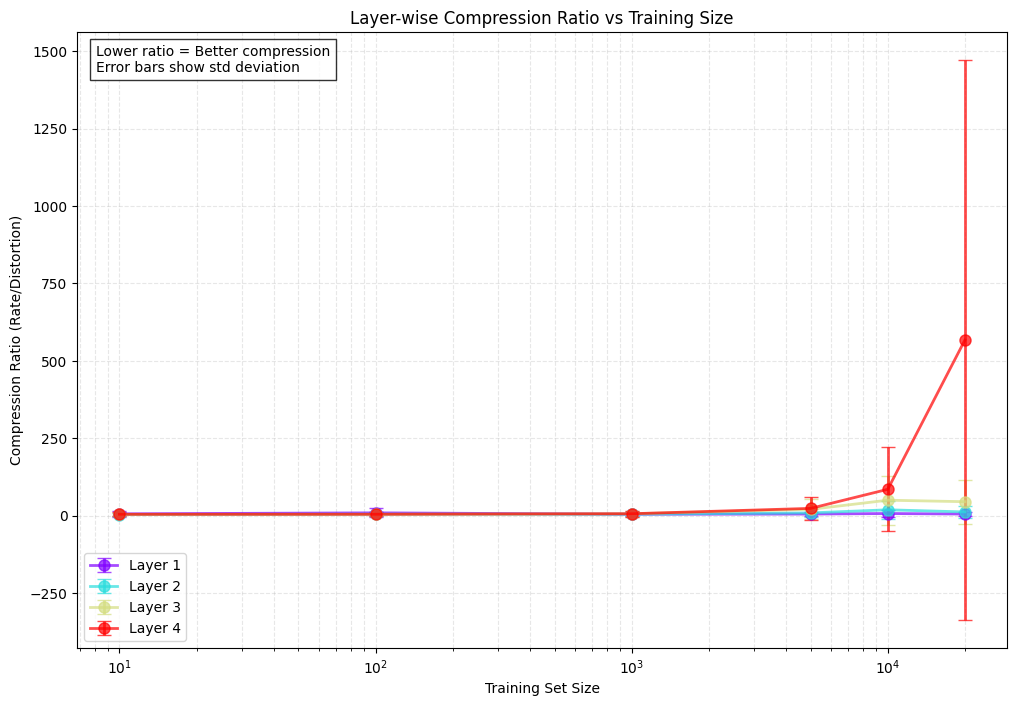

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def calculate_compression_stats(rd_points):
    """Calculate mean and variance of compression ratio for a set of R(D) points"""
    ratios = [p['rate']/p['distortion'] for p in rd_points]
    return np.mean(ratios), np.std(ratios)

def analyze_compression_ratios(file_path):
    # Load results
    with open(file_path, 'r') as f:
        results = json.load(f)
    
    # Dictionary to store results per layer per training size
    layer_stats = defaultdict(lambda: defaultdict(list))
    
    # Process each result
    for result in results:
        n_train = result['model_config']['n_train']
        
        # Process each layer
        for layer_data in result['layer_results']:
            layer_idx = layer_data['layer_idx']
            mean_ratio, std_ratio = calculate_compression_stats(layer_data['rd_points'])
            layer_stats[layer_idx][n_train].append((mean_ratio, std_ratio))
    
    # Calculate average stats for each layer and training size
    final_stats = defaultdict(lambda: defaultdict(dict))
    for layer_idx in layer_stats:
        for n_train in layer_stats[layer_idx]:
            ratios = layer_stats[layer_idx][n_train]
            means, stds = zip(*ratios)
            final_stats[layer_idx][n_train] = {
                'mean': np.mean(means),
                'std': np.mean(stds)
            }
    
    return final_stats

def plot_compression_ratios(stats):
    plt.figure(figsize=(12, 8))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(stats)))
    
    for layer_idx, color in zip(sorted(stats.keys()), colors):
        layer_data = stats[layer_idx]
        n_trains = sorted(layer_data.keys())
        means = [layer_data[n]['mean'] for n in n_trains]
        stds = [layer_data[n]['std'] for n in n_trains]
        
        plt.errorbar(n_trains, means, yerr=stds, label=f'Layer {layer_idx+1}',
                    color=color, marker='o', capsize=5, markersize=8,
                    linestyle='-', linewidth=2, alpha=0.7)
    
    plt.xscale('log')
    plt.xlabel('Training Set Size')
    plt.ylabel('Compression Ratio (Rate/Distortion)')
    plt.title('Layer-wise Compression Ratio vs Training Size')
    plt.grid(True, which='both', linestyle='--', alpha=0.3)
    plt.legend()
    
    # Add text box with explanation
    plt.text(0.02, 0.98, 'Lower ratio = Better compression\nError bars show std deviation',
             transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')
    
    return plt

# Usage
file_path = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_1_modelsaved/rate_distortion_analysis_20250125_153042.json"
stats = analyze_compression_ratios(file_path)
plt = plot_compression_ratios(stats)
plt.show()

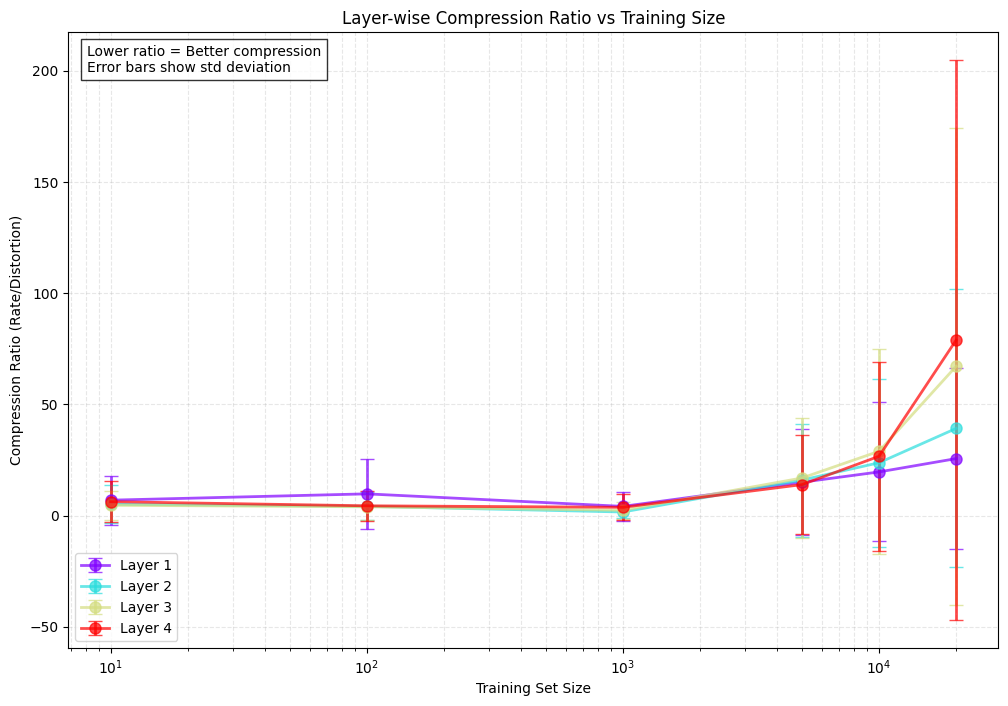

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def calculate_compression_stats(rd_points):
    """Calculate mean and variance of compression ratio for a set of R(D) points"""
    ratios = [p['rate']/p['distortion'] for p in rd_points]
    return np.mean(ratios), np.std(ratios)

def analyze_compression_ratios(file_path):
    # Load results
    with open(file_path, 'r') as f:
        results = json.load(f)
    
    # Dictionary to store results per layer per training size
    layer_stats = defaultdict(lambda: defaultdict(list))
    
    # Process each result
    for result in results:
        n_train = result['model_config']['n_train']
        
        # Process each layer
        for layer_data in result['layer_results']:
            layer_idx = layer_data['layer_idx']
            mean_ratio, std_ratio = calculate_compression_stats(layer_data['rd_points'])
            layer_stats[layer_idx][n_train].append((mean_ratio, std_ratio))
    
    # Calculate average stats for each layer and training size
    final_stats = defaultdict(lambda: defaultdict(dict))
    for layer_idx in layer_stats:
        for n_train in layer_stats[layer_idx]:
            ratios = layer_stats[layer_idx][n_train]
            means, stds = zip(*ratios)
            final_stats[layer_idx][n_train] = {
                'mean': np.mean(means),
                'std': np.mean(stds)
            }
    
    return final_stats

def plot_compression_ratios(stats):
    plt.figure(figsize=(12, 8))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(stats)))
    
    for layer_idx, color in zip(sorted(stats.keys()), colors):
        layer_data = stats[layer_idx]
        n_trains = sorted(layer_data.keys())
        means = [layer_data[n]['mean'] for n in n_trains]
        stds = [layer_data[n]['std'] for n in n_trains]
        
        plt.errorbar(n_trains, means, yerr=stds, label=f'Layer {layer_idx+1}',
                    color=color, marker='o', capsize=5, markersize=8,
                    linestyle='-', linewidth=2, alpha=0.7)
    
    plt.xscale('log')
    plt.xlabel('Training Set Size')
    plt.ylabel('Compression Ratio (Rate/Distortion)')
    plt.title('Layer-wise Compression Ratio vs Training Size')
    plt.grid(True, which='both', linestyle='--', alpha=0.3)
    plt.legend()
    
    # Add text box with explanation
    plt.text(0.02, 0.98, 'Lower ratio = Better compression\nError bars show std deviation',
             transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')
    
    return plt

# Usage
file_path = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_1_modelsaved/rate_distortion_analysis_20250125_153135.json"
stats = analyze_compression_ratios(file_path)
plt = plot_compression_ratios(stats)
plt.show()

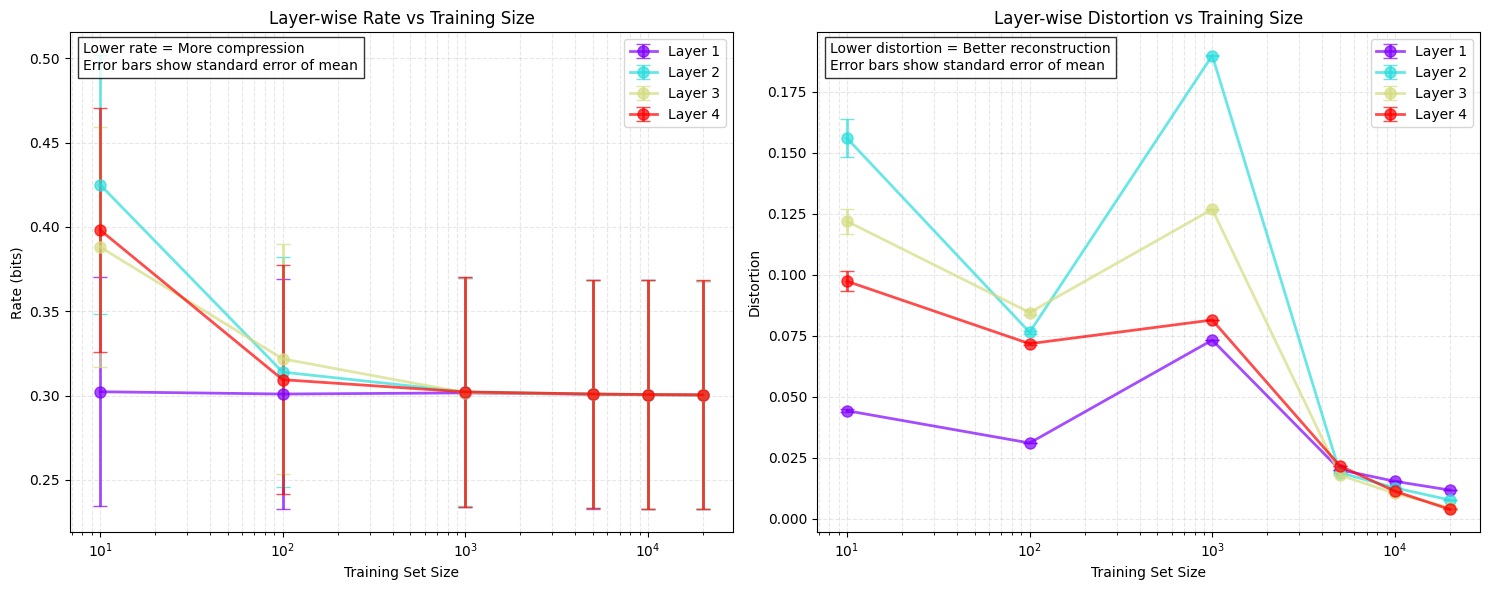

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def calculate_separate_stats(rd_points):
    """Calculate mean and standard error of the mean (SEM) for rates and distortions"""
    rates = [p['rate'] for p in rd_points]
    distortions = [p['distortion'] for p in rd_points]
    n = len(rd_points)
    return {
        'rate_mean': np.mean(rates),
        'rate_sem': np.std(rates) / np.sqrt(n),
        'distortion_mean': np.mean(distortions),
        'distortion_sem': np.std(distortions) / np.sqrt(n)
    }

def analyze_separate_metrics(file_path):
    # Load results
    with open(file_path, 'r') as f:
        results = json.load(f)
    
    # Dictionary to store results per layer per training size
    layer_stats = defaultdict(lambda: defaultdict(list))
    
    # Process each result
    for result in results:
        n_train = result['model_config']['n_train']
        
        # Process each layer
        for layer_data in result['layer_results']:
            layer_idx = layer_data['layer_idx']
            stats = calculate_separate_stats(layer_data['rd_points'])
            layer_stats[layer_idx][n_train].append(stats)
    
    # Calculate average stats for each layer and training size
    final_stats = defaultdict(lambda: defaultdict(dict))
    for layer_idx in layer_stats:
        for n_train in layer_stats[layer_idx]:
            stats_list = layer_stats[layer_idx][n_train]
            final_stats[layer_idx][n_train] = {
                'rate_mean': np.mean([s['rate_mean'] for s in stats_list]),
                'rate_sem': np.mean([s['rate_sem'] for s in stats_list]),
                'distortion_mean': np.mean([s['distortion_mean'] for s in stats_list]),
                'distortion_sem': np.mean([s['distortion_sem'] for s in stats_list])
            }
    
    return final_stats

def plot_separate_metrics(stats):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(stats)))
    
    for layer_idx, color in zip(sorted(stats.keys()), colors):
        layer_data = stats[layer_idx]
        n_trains = sorted(layer_data.keys())
        
        # Rate plot
        rate_means = [layer_data[n]['rate_mean'] for n in n_trains]
        rate_sems = [layer_data[n]['rate_sem'] for n in n_trains]
        ax1.errorbar(n_trains, rate_means, yerr=rate_sems, 
                    label=f'Layer {layer_idx+1}',
                    color=color, marker='o', capsize=5, markersize=8,
                    linestyle='-', linewidth=2, alpha=0.7)
        
        # Distortion plot
        dist_means = [layer_data[n]['distortion_mean'] for n in n_trains]
        dist_sems = [layer_data[n]['distortion_sem'] for n in n_trains]
        ax2.errorbar(n_trains, dist_means, yerr=dist_sems,
                    label=f'Layer {layer_idx+1}',
                    color=color, marker='o', capsize=5, markersize=8,
                    linestyle='-', linewidth=2, alpha=0.7)
    
    # Configure Rate plot
    ax1.set_xscale('log')
    ax1.set_xlabel('Training Set Size')
    ax1.set_ylabel('Rate (bits)')
    ax1.set_title('Layer-wise Rate vs Training Size')
    ax1.grid(True, which='both', linestyle='--', alpha=0.3)
    ax1.legend()
    
    # Configure Distortion plot
    ax2.set_xscale('log')
    ax2.set_xlabel('Training Set Size')
    ax2.set_ylabel('Distortion')
    ax2.set_title('Layer-wise Distortion vs Training Size')
    ax2.grid(True, which='both', linestyle='--', alpha=0.3)
    ax2.legend()
    
    # Add text boxes with explanations
    ax1.text(0.02, 0.98, 'Lower rate = More compression\nError bars show standard error of mean',
             transform=ax1.transAxes, bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')
    ax2.text(0.02, 0.98, 'Lower distortion = Better reconstruction\nError bars show standard error of mean',
             transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')
    
    plt.tight_layout()
    return plt

# Usage
file_path =  "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_1_modelsaved/rate_distortion_analysis_20250125_153135.json"  # Update with your path
stats = analyze_separate_metrics(file_path)
plt = plot_separate_metrics(stats)
plt.show()

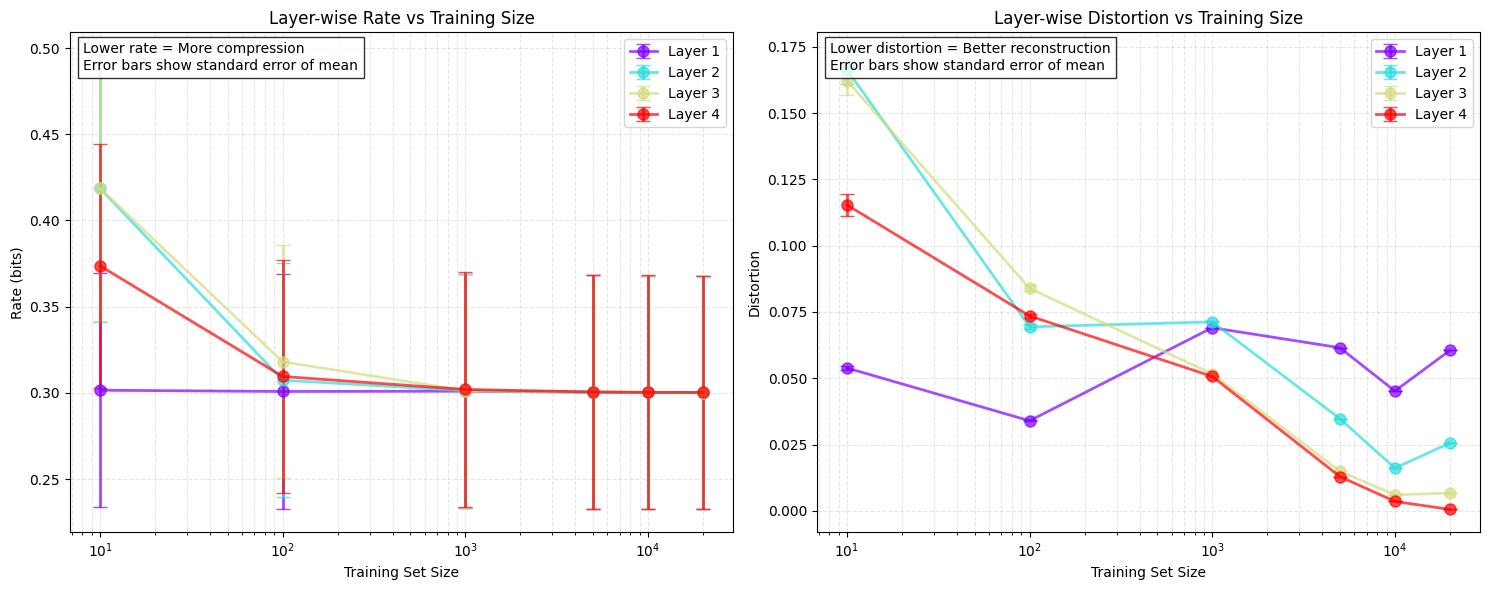

In [7]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def calculate_separate_stats(rd_points):
    """Calculate mean and standard error of the mean (SEM) for rates and distortions"""
    rates = [p['rate'] for p in rd_points]
    distortions = [p['distortion'] for p in rd_points]
    n = len(rd_points)
    return {
        'rate_mean': np.mean(rates),
        'rate_sem': np.std(rates) / np.sqrt(n),
        'distortion_mean': np.mean(distortions),
        'distortion_sem': np.std(distortions) / np.sqrt(n)
    }

def analyze_separate_metrics(file_path):
    # Load results
    with open(file_path, 'r') as f:
        results = json.load(f)
    
    # Dictionary to store results per layer per training size
    layer_stats = defaultdict(lambda: defaultdict(list))
    
    # Process each result
    for result in results:
        n_train = result['model_config']['n_train']
        
        # Process each layer
        for layer_data in result['layer_results']:
            layer_idx = layer_data['layer_idx']
            stats = calculate_separate_stats(layer_data['rd_points'])
            layer_stats[layer_idx][n_train].append(stats)
    
    # Calculate average stats for each layer and training size
    final_stats = defaultdict(lambda: defaultdict(dict))
    for layer_idx in layer_stats:
        for n_train in layer_stats[layer_idx]:
            stats_list = layer_stats[layer_idx][n_train]
            final_stats[layer_idx][n_train] = {
                'rate_mean': np.mean([s['rate_mean'] for s in stats_list]),
                'rate_sem': np.mean([s['rate_sem'] for s in stats_list]),
                'distortion_mean': np.mean([s['distortion_mean'] for s in stats_list]),
                'distortion_sem': np.mean([s['distortion_sem'] for s in stats_list])
            }
    
    return final_stats

def plot_separate_metrics(stats):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(stats)))
    
    for layer_idx, color in zip(sorted(stats.keys()), colors):
        layer_data = stats[layer_idx]
        n_trains = sorted(layer_data.keys())
        
        # Rate plot
        rate_means = [layer_data[n]['rate_mean'] for n in n_trains]
        rate_sems = [layer_data[n]['rate_sem'] for n in n_trains]
        ax1.errorbar(n_trains, rate_means, yerr=rate_sems, 
                    label=f'Layer {layer_idx+1}',
                    color=color, marker='o', capsize=5, markersize=8,
                    linestyle='-', linewidth=2, alpha=0.7)
        
        # Distortion plot
        dist_means = [layer_data[n]['distortion_mean'] for n in n_trains]
        dist_sems = [layer_data[n]['distortion_sem'] for n in n_trains]
        ax2.errorbar(n_trains, dist_means, yerr=dist_sems,
                    label=f'Layer {layer_idx+1}',
                    color=color, marker='o', capsize=5, markersize=8,
                    linestyle='-', linewidth=2, alpha=0.7)
    
    # Configure Rate plot
    ax1.set_xscale('log')
    ax1.set_xlabel('Training Set Size')
    ax1.set_ylabel('Rate (bits)')
    ax1.set_title('Layer-wise Rate vs Training Size')
    ax1.grid(True, which='both', linestyle='--', alpha=0.3)
    ax1.legend()
    
    # Configure Distortion plot
    ax2.set_xscale('log')
    ax2.set_xlabel('Training Set Size')
    ax2.set_ylabel('Distortion')
    ax2.set_title('Layer-wise Distortion vs Training Size')
    ax2.grid(True, which='both', linestyle='--', alpha=0.3)
    ax2.legend()
    
    # Add text boxes with explanations
    ax1.text(0.02, 0.98, 'Lower rate = More compression\nError bars show standard error of mean',
             transform=ax1.transAxes, bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')
    ax2.text(0.02, 0.98, 'Lower distortion = Better reconstruction\nError bars show standard error of mean',
             transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')
    
    plt.tight_layout()
    return plt

# Usage
file_path =  "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_1_modelsaved/rate_distortion_analysis_20250125_153042.json"  # Update with your path
stats = analyze_separate_metrics(file_path)
plt = plot_separate_metrics(stats)
plt.show()

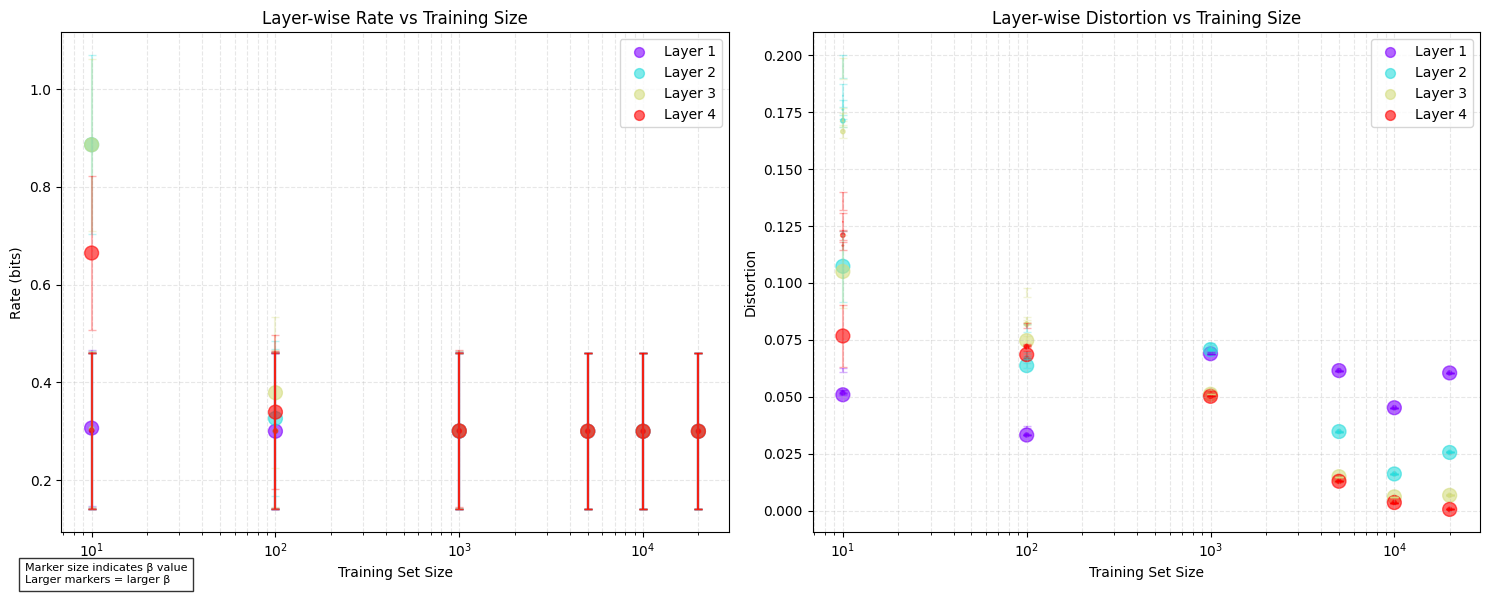

In [8]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def calculate_beta_stats(rd_points):
    """Calculate mean and SEM for each beta value"""
    # Group by beta
    beta_groups = defaultdict(list)
    for p in rd_points:
        beta_groups[p['beta']].append(p)
    
    stats = []
    for beta, points in beta_groups.items():
        rates = [p['rate'] for p in points]
        distortions = [p['distortion'] for p in points]
        n = len(points)
        stats.append({
            'beta': beta,
            'rate_mean': np.mean(rates),
            'rate_sem': np.std(rates) / np.sqrt(max(1, n-1)),
            'distortion_mean': np.mean(distortions),
            'distortion_sem': np.std(distortions) / np.sqrt(max(1, n-1))
        })
    return stats

def analyze_with_betas(file_path):
    with open(file_path, 'r') as f:
        results = json.load(f)
    
    # Dictionary to store results per layer per training size
    layer_stats = defaultdict(lambda: defaultdict(list))
    
    for result in results:
        n_train = result['model_config']['n_train']
        
        for layer_data in result['layer_results']:
            layer_idx = layer_data['layer_idx']
            beta_stats = calculate_beta_stats(layer_data['rd_points'])
            layer_stats[layer_idx][n_train].extend(beta_stats)
    
    return layer_stats

def plot_beta_preserved_metrics(stats):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(stats)))
    
    for layer_idx, color in zip(sorted(stats.keys()), colors):
        layer_data = stats[layer_idx]
        n_trains = sorted(layer_data.keys())
        
        for n_train in n_trains:
            beta_points = layer_data[n_train]
            
            # Sort by beta for consistent marker sizes
            beta_points.sort(key=lambda x: x['beta'])
            
            # Scale marker size by beta value
            betas = [p['beta'] for p in beta_points]
            sizes = 100 * np.array(betas) / max(betas)  # Scale marker sizes
            
            # Rate plot
            ax1.scatter(
                [n_train] * len(beta_points),
                [p['rate_mean'] for p in beta_points],
                s=sizes,
                color=color,
                alpha=0.6,
                label=f'Layer {layer_idx+1}' if n_train == n_trains[0] else ""
            )
            # Add error bars
            for point in beta_points:
                ax1.errorbar(
                    n_train,
                    point['rate_mean'],
                    yerr=point['rate_sem'],
                    color=color,
                    alpha=0.3,
                    capsize=3
                )
            
            # Distortion plot
            ax2.scatter(
                [n_train] * len(beta_points),
                [p['distortion_mean'] for p in beta_points],
                s=sizes,
                color=color,
                alpha=0.6,
                label=f'Layer {layer_idx+1}' if n_train == n_trains[0] else ""
            )
            # Add error bars
            for point in beta_points:
                ax2.errorbar(
                    n_train,
                    point['distortion_mean'],
                    yerr=point['distortion_sem'],
                    color=color,
                    alpha=0.3,
                    capsize=3
                )
    
    # Configure Rate plot
    ax1.set_xscale('log')
    ax1.set_xlabel('Training Set Size')
    ax1.set_ylabel('Rate (bits)')
    ax1.set_title('Layer-wise Rate vs Training Size')
    ax1.grid(True, which='both', linestyle='--', alpha=0.3)
    ax1.legend()
    
    # Configure Distortion plot
    ax2.set_xscale('log')
    ax2.set_xlabel('Training Set Size')
    ax2.set_ylabel('Distortion')
    ax2.set_title('Layer-wise Distortion vs Training Size')
    ax2.grid(True, which='both', linestyle='--', alpha=0.3)
    ax2.legend()
    
    # Add explanatory text
    fig.text(0.02, 0.02, 'Marker size indicates β value\nLarger markers = larger β',
             fontsize=8, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return plt

# Usage
file_path = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_1_modelsaved/rate_distortion_analysis_20250125_153042.json"  # Update with your path
stats = analyze_with_betas(file_path)
plt = plot_beta_preserved_metrics(stats)
plt.show()

/tmp/ipykernel_984651/1104592520.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(rates, distortions)
/tmp/ipykernel_984651/1104592520.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  boot_area = np.trapz(boot_rates, boot_distortions)


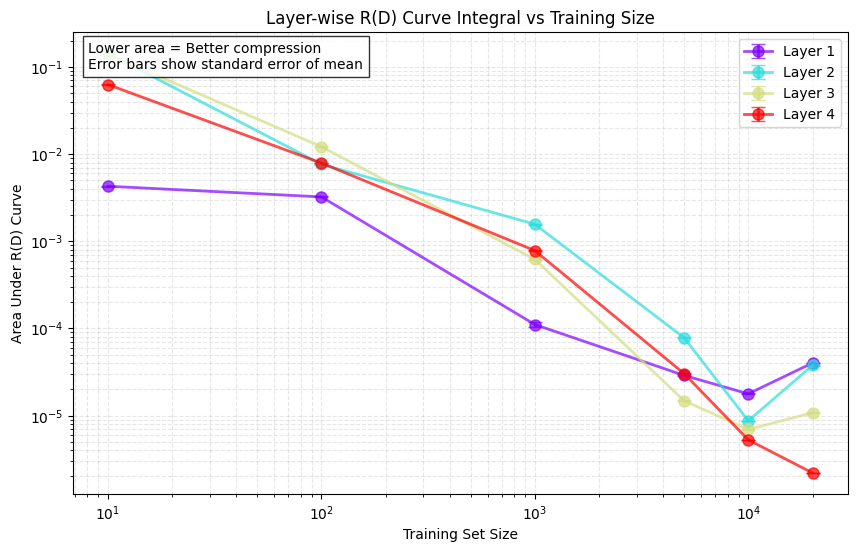

In [11]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def calculate_rd_integral(rd_points):
    """Calculate area under R(D) curve using numpy's trapezoidal integration"""
    # Sort points by distortion
    sorted_points = sorted(rd_points, key=lambda x: x['distortion'])
    distortions = [p['distortion'] for p in sorted_points]
    rates = [p['rate'] for p in sorted_points]
    
    # Calculate area using numpy's trapezoidal rule
    area = np.trapz(rates, distortions)
    
    # Calculate standard error through bootstrap
    n_bootstrap = 1000
    bootstrap_areas = []
    n_points = len(rd_points)
    
    for _ in range(n_bootstrap):
        indices = np.random.randint(0, n_points, n_points)
        boot_points = [rd_points[i] for i in indices]
        boot_points = sorted(boot_points, key=lambda x: x['distortion'])
        boot_distortions = [p['distortion'] for p in boot_points]
        boot_rates = [p['rate'] for p in boot_points]
        boot_area = np.trapz(boot_rates, boot_distortions)
        bootstrap_areas.append(boot_area)
    
    area_sem = np.std(bootstrap_areas) / np.sqrt(n_bootstrap)
    
    return area, area_sem

def analyze_rd_integrals(file_path):
    with open(file_path, 'r') as f:
        results = json.load(f)
    
    # Dictionary to store results per layer per training size
    layer_stats = defaultdict(lambda: defaultdict(list))
    
    for result in results:
        n_train = result['model_config']['n_train']
        
        for layer_data in result['layer_results']:
            layer_idx = layer_data['layer_idx']
            area, area_sem = calculate_rd_integral(layer_data['rd_points'])
            layer_stats[layer_idx][n_train].append((area, area_sem))
    
    # Average over multiple runs if they exist
    final_stats = defaultdict(dict)
    for layer_idx in layer_stats:
        for n_train in layer_stats[layer_idx]:
            areas, sems = zip(*layer_stats[layer_idx][n_train])
            mean_area = np.mean(areas)
            # Combine SEMs appropriately
            combined_sem = np.sqrt(np.sum(np.array(sems)**2)) / len(sems)
            final_stats[layer_idx][n_train] = (mean_area, combined_sem)
    
    return final_stats

def plot_rd_integrals(stats):
    plt.figure(figsize=(10, 6))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(stats)))
    
    for layer_idx, color in zip(sorted(stats.keys()), colors):
        layer_data = stats[layer_idx]
        n_trains = sorted(layer_data.keys())
        areas = [layer_data[n][0] for n in n_trains]
        sems = [layer_data[n][1] for n in n_trains]
        
        plt.errorbar(n_trains, areas, yerr=sems,
                    label=f'Layer {layer_idx+1}',
                    color=color, marker='o', capsize=5,
                    markersize=8, linestyle='-', linewidth=2,
                    alpha=0.7)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Training Set Size')
    plt.ylabel('Area Under R(D) Curve')
    plt.title('Layer-wise R(D) Curve Integral vs Training Size')
    plt.grid(True, which='both', linestyle='--', alpha=0.3)
    plt.legend()
    
    # Add explanatory text
    plt.text(0.02, 0.98, 'Lower area = Better compression\nError bars show standard error of mean',
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')
    
    return plt

# Usage
file_path = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_1_modelsaved/rate_distortion_analysis_20250125_153042.json"  # Update with your path
stats = analyze_rd_integrals(file_path)
plt = plot_rd_integrals(stats)
plt.show()

/tmp/ipykernel_984651/2945532949.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(rates, distortions)
/tmp/ipykernel_984651/2945532949.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  boot_area = np.trapz(boot_rates, boot_distortions)


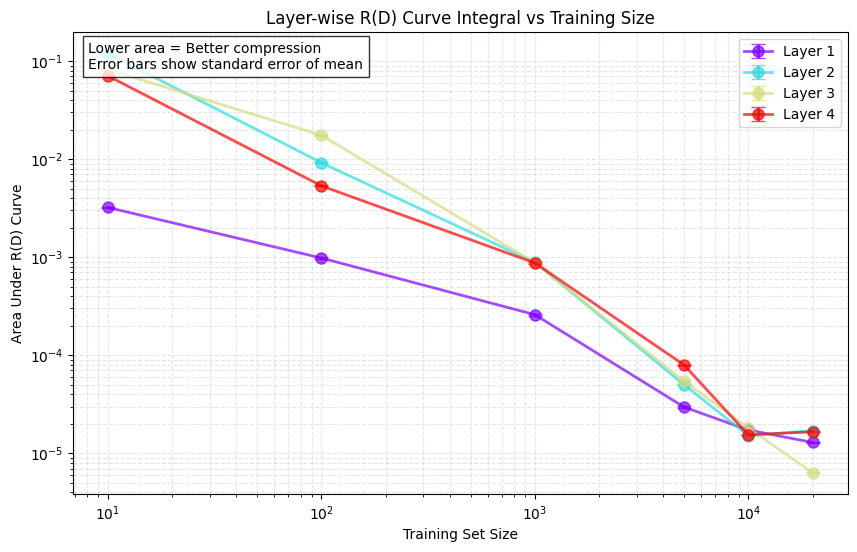

In [12]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def calculate_rd_integral(rd_points):
    """Calculate area under R(D) curve using numpy's trapezoidal integration"""
    # Sort points by distortion
    sorted_points = sorted(rd_points, key=lambda x: x['distortion'])
    distortions = [p['distortion'] for p in sorted_points]
    rates = [p['rate'] for p in sorted_points]
    
    # Calculate area using numpy's trapezoidal rule
    area = np.trapz(rates, distortions)
    
    # Calculate standard error through bootstrap
    n_bootstrap = 1000
    bootstrap_areas = []
    n_points = len(rd_points)
    
    for _ in range(n_bootstrap):
        indices = np.random.randint(0, n_points, n_points)
        boot_points = [rd_points[i] for i in indices]
        boot_points = sorted(boot_points, key=lambda x: x['distortion'])
        boot_distortions = [p['distortion'] for p in boot_points]
        boot_rates = [p['rate'] for p in boot_points]
        boot_area = np.trapz(boot_rates, boot_distortions)
        bootstrap_areas.append(boot_area)
    
    area_sem = np.std(bootstrap_areas) / np.sqrt(n_bootstrap)
    
    return area, area_sem

def analyze_rd_integrals(file_path):
    with open(file_path, 'r') as f:
        results = json.load(f)
    
    # Dictionary to store results per layer per training size
    layer_stats = defaultdict(lambda: defaultdict(list))
    
    for result in results:
        n_train = result['model_config']['n_train']
        
        for layer_data in result['layer_results']:
            layer_idx = layer_data['layer_idx']
            area, area_sem = calculate_rd_integral(layer_data['rd_points'])
            layer_stats[layer_idx][n_train].append((area, area_sem))
    
    # Average over multiple runs if they exist
    final_stats = defaultdict(dict)
    for layer_idx in layer_stats:
        for n_train in layer_stats[layer_idx]:
            areas, sems = zip(*layer_stats[layer_idx][n_train])
            mean_area = np.mean(areas)
            # Combine SEMs appropriately
            combined_sem = np.sqrt(np.sum(np.array(sems)**2)) / len(sems)
            final_stats[layer_idx][n_train] = (mean_area, combined_sem)
    
    return final_stats

def plot_rd_integrals(stats):
    plt.figure(figsize=(10, 6))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(stats)))
    
    for layer_idx, color in zip(sorted(stats.keys()), colors):
        layer_data = stats[layer_idx]
        n_trains = sorted(layer_data.keys())
        areas = [layer_data[n][0] for n in n_trains]
        sems = [layer_data[n][1] for n in n_trains]
        
        plt.errorbar(n_trains, areas, yerr=sems,
                    label=f'Layer {layer_idx+1}',
                    color=color, marker='o', capsize=5,
                    markersize=8, linestyle='-', linewidth=2,
                    alpha=0.7)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Training Set Size')
    plt.ylabel('Area Under R(D) Curve')
    plt.title('Layer-wise R(D) Curve Integral vs Training Size')
    plt.grid(True, which='both', linestyle='--', alpha=0.3)
    plt.legend()
    
    # Add explanatory text
    plt.text(0.02, 0.98, 'Lower area = Better compression\nError bars show standard error of mean',
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')
    
    return plt

# Usage
file_path = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_1_modelsaved/rate_distortion_analysis_20250125_153135.json"  # Update with your path
stats = analyze_rd_integrals(file_path)
plt = plot_rd_integrals(stats)
plt.show()

In [ ]:
####

In [13]:
import torch
import numpy as np
from collections import defaultdict

class MSPFunction:
    def __init__(self, P: int, sets: list):
        self.P = P
        self.sets = [set(s) for s in sets]  # Convert lists to sets
    
    def evaluate(self, z: torch.Tensor) -> torch.Tensor:
        device = z.device
        batch_size = z.shape[0]
        result = torch.zeros(batch_size, dtype=torch.float32, device=device)
        
        for S in self.sets:
            term = torch.ones(batch_size, dtype=torch.float32, device=device)
            for idx in S:
                term = term * z[:, idx]
            result = result + term
            
        return result

def verify_shuffling(shuffled_path: str, nonshuffled_path: str, msp_sets: list):
    # Load datasets
    shuffled_data = torch.load(shuffled_path)
    nonshuffled_data = torch.load(nonshuffled_path)
    
    # Extract X and y
    X_shuffled = shuffled_data['X']
    y_shuffled = shuffled_data['y']
    X_nonshuffled = nonshuffled_data['X']
    y_nonshuffled = nonshuffled_data['y']
    
    print("Basic Checks:")
    print(f"Shapes - Shuffled: X={X_shuffled.shape}, y={y_shuffled.shape}")
    print(f"Shapes - Non-shuffled: X={X_nonshuffled.shape}, y={y_nonshuffled.shape}")
    
    # Check if X values are identical
    x_identical = torch.allclose(X_shuffled, X_nonshuffled)
    print(f"\nInput data (X) identical: {x_identical}")
    
    # Check if y values are different
    y_different = not torch.allclose(y_shuffled, y_nonshuffled)
    print(f"Labels (y) are different: {y_different}")
    
    # Compare label distributions
    print("\nLabel Statistics:")
    print(f"Shuffled - Mean: {y_shuffled.mean():.4f}, Std: {y_shuffled.std():.4f}")
    print(f"Non-shuffled - Mean: {y_nonshuffled.mean():.4f}, Std: {y_nonshuffled.std():.4f}")
    
    # Verify correctness of non-shuffled labels
    msp = MSPFunction(8, msp_sets)  # P=8 from your code
    y_computed = msp.evaluate(X_nonshuffled)
    nonshuffled_correct = torch.allclose(y_computed, y_nonshuffled, rtol=1e-4)
    print(f"\nNon-shuffled labels match MSP function: {nonshuffled_correct}")
    
    # Check if shuffled labels are a permutation of non-shuffled
    sorted_shuffled = torch.sort(y_shuffled)[0]
    sorted_nonshuffled = torch.sort(y_nonshuffled)[0]
    is_permutation = torch.allclose(sorted_shuffled, sorted_nonshuffled, rtol=1e-4)
    print(f"Shuffled labels are a permutation of non-shuffled: {is_permutation}")
    
    # Check correlation between inputs and outputs
    corr_shuffled = torch.corrcoef(torch.stack([X_shuffled[:, 0], y_shuffled]))[0, 1]
    corr_nonshuffled = torch.corrcoef(torch.stack([X_nonshuffled[:, 0], y_nonshuffled]))[0, 1]
    print(f"\nInput-Output Correlation:")
    print(f"Shuffled: {corr_shuffled:.4f}")
    print(f"Non-shuffled: {corr_nonshuffled:.4f}")
    
    return {
        'x_identical': x_identical,
        'y_different': y_different,
        'nonshuffled_correct': nonshuffled_correct,
        'is_permutation': is_permutation,
        'correlation_change': abs(corr_shuffled - corr_nonshuffled)
    }

# MSP sets from your code
msp_sets = [[7], [2,7], [0,2,7], [5,7,4], [1], [0,4], [3,7], [0,1,2,3,4,6,7]]

# Example usage
shuffled_path = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_1_modelsaved/train_dataset_h400_d4_n20000_lr0.005_g1.0_mup_pennington_shuffled_20250125_153042_rank0.pt"    # Update with actual path
nonshuffled_path = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_1_modelsaved/train_dataset_h400_d4_n20000_lr0.005_g1.0_mup_pennington_20250125_153135_rank0.pt"  # Update with actual path

results = verify_shuffling(shuffled_path, nonshuffled_path, msp_sets)

/tmp/ipykernel_984651/2463353004.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  shuffled_data = torch.load(shuffled_path)
/tmp/ipykernel_984651/2463353004.py:26: Futur

Basic Checks:
Shapes - Shuffled: X=torch.Size([20000, 30]), y=torch.Size([20000])
Shapes - Non-shuffled: X=torch.Size([20000, 30]), y=torch.Size([20000])

Input data (X) identical: False
Labels (y) are different: True

Label Statistics:
Shuffled - Mean: -0.0185, Std: 2.8205
Non-shuffled - Mean: 0.0133, Std: 2.8274

Non-shuffled labels match MSP function: True
Shuffled labels are a permutation of non-shuffled: False

Input-Output Correlation:
Shuffled: 0.0043
Non-shuffled: 0.0080


In [14]:
import torch
import numpy as np

class MSPFunction:
    def __init__(self, P: int, sets: list):
        self.P = P
        self.sets = [set(s) for s in sets]
    
    def evaluate(self, z: torch.Tensor) -> torch.Tensor:
        device = z.device
        batch_size = z.shape[0]
        result = torch.zeros(batch_size, dtype=torch.float32, device=device)
        
        for S in self.sets:
            term = torch.ones(batch_size, dtype=torch.float32, device=device)
            for idx in S:
                term = term * z[:, idx]
            result = result + term
        
        return result

def verify_shuffling_with_msp(shuffled_path: str, nonshuffled_path: str, msp_sets: list):
    # Load datasets
    shuffled_data = torch.load(shuffled_path, weights_only=True)
    nonshuffled_data = torch.load(nonshuffled_path, weights_only=True)
    
    # Create MSP function
    msp = MSPFunction(8, msp_sets)
    
    # Compute expected y values for both datasets
    y_expected_shuffled = msp.evaluate(shuffled_data['X'])
    y_expected_nonshuffled = msp.evaluate(nonshuffled_data['X'])
    
    # Compare with actual y values
    shuffled_matches = torch.allclose(y_expected_shuffled, shuffled_data['y'], rtol=1e-4)
    nonshuffled_matches = torch.allclose(y_expected_nonshuffled, nonshuffled_data['y'], rtol=1e-4)
    
    print("\nVerification Results:")
    print(f"Non-shuffled labels match MSP function: {nonshuffled_matches}")
    print(f"Shuffled labels match MSP function: {shuffled_matches}")
    
    if nonshuffled_matches and not shuffled_matches:
        print("\nSHUFFLING VERIFIED: Labels are properly shuffled!")
    elif nonshuffled_matches and shuffled_matches:
        print("\nWARNING: Both datasets appear to be non-shuffled!")
    elif not nonshuffled_matches and not shuffled_matches:
        print("\nWARNING: Neither dataset matches expected MSP values!")
    
    # Print some detailed statistics
    print("\nDetailed Analysis:")
    for name, data, expected in [("Shuffled", shuffled_data, y_expected_shuffled),
                               ("Non-shuffled", nonshuffled_data, y_expected_nonshuffled)]:
        mse = torch.mean((data['y'] - expected) ** 2)
        correlation = torch.corrcoef(torch.stack([data['y'], expected]))[0,1]
        print(f"\n{name} dataset:")
        print(f"MSE with expected values: {mse:.6f}")
        print(f"Correlation with expected values: {correlation:.6f}")
        print(f"Label mean: {data['y'].mean():.4f}, std: {data['y'].std():.4f}")
        print(f"Expected mean: {expected.mean():.4f}, std: {expected.std():.4f}")

# MSP sets from your code
msp_sets = [[7], [2,7], [0,2,7], [5,7,4], [1], [0,4], [3,7], [0,1,2,3,4,6,7]]


#Example usage
shuffled_path = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_true_mup_lr0005_gamma_1_modelsaved/train_dataset_h400_d4_n20000_lr0.005_g1.0_mup_pennington_shuffled_20250125_153042_rank0.pt"    # Update with actual path
nonshuffled_path = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_1_modelsaved/train_dataset_h400_d4_n20000_lr0.005_g1.0_mup_pennington_20250125_153135_rank0.pt"  # Update with actual path

verify_shuffling_with_msp(shuffled_path, nonshuffled_path, msp_sets)


Verification Results:
Non-shuffled labels match MSP function: True
Shuffled labels match MSP function: False

SHUFFLING VERIFIED: Labels are properly shuffled!

Detailed Analysis:

Shuffled dataset:
MSE with expected values: 15.932400
Correlation with expected values: -0.001401
Label mean: -0.0185, std: 2.8205
Expected mean: -0.0185, std: 2.8205

Non-shuffled dataset:
MSE with expected values: 0.000000
Correlation with expected values: 1.000000
Label mean: 0.0133, std: 2.8274
Expected mean: 0.0133, std: 2.8274


In [ ]:
import torch
import numpy as np

class MSPFunction:
    def __init__(self, P: int, sets: list):
        self.P = P
        self.sets = [set(s) for s in sets]
    
    def evaluate(self, z: torch.Tensor) -> torch.Tensor:
        device = z.device
        batch_size = z.shape[0]
        result = torch.zeros(batch_size, dtype=torch.float32, device=device)
        
        for S in self.sets:
            term = torch.ones(batch_size, dtype=torch.float32, device=device)
            for idx in S:
                term = term * z[:, idx]
            result = result + term
        
        return result

def verify_shuffling_with_msp(shuffled_path: str, nonshuffled_path: str, msp_sets: list):
    # Load datasets
    shuffled_data = torch.load(shuffled_path, weights_only=True)
    nonshuffled_data = torch.load(nonshuffled_path, weights_only=True)
    
    # Create MSP function
    msp = MSPFunction(8, msp_sets)
    
    # Compute expected y values for both datasets
    y_expected_shuffled = msp.evaluate(shuffled_data['X'])
    y_expected_nonshuffled = msp.evaluate(nonshuffled_data['X'])
    
    # Compare with actual y values
    shuffled_matches = torch.allclose(y_expected_shuffled, shuffled_data['y'], rtol=1e-4)
    nonshuffled_matches = torch.allclose(y_expected_nonshuffled, nonshuffled_data['y'], rtol=1e-4)
    
    print("\nVerification Results:")
    print(f"Non-shuffled labels match MSP function: {nonshuffled_matches}")
    print(f"Shuffled labels match MSP function: {shuffled_matches}")
    
    if nonshuffled_matches and not shuffled_matches:
        print("\nSHUFFLING VERIFIED: Labels are properly shuffled!")
    elif nonshuffled_matches and shuffled_matches:
        print("\nWARNING: Both datasets appear to be non-shuffled!")
    elif not nonshuffled_matches and not shuffled_matches:
        print("\nWARNING: Neither dataset matches expected MSP values!")
    
    # Print some detailed statistics
    print("\nDetailed Analysis:")
    for name, data, expected in [("Shuffled", shuffled_data, y_expected_shuffled),
                               ("Non-shuffled", nonshuffled_data, y_expected_nonshuffled)]:
        mse = torch.mean((data['y'] - expected) ** 2)
        correlation = torch.corrcoef(torch.stack([data['y'], expected]))[0,1]
        print(f"\n{name} dataset:")
        print(f"MSE with expected values: {mse:.6f}")
        print(f"Correlation with expected values: {correlation:.6f}")
        print(f"Label mean: {data['y'].mean():.4f}, std: {data['y'].std():.4f}")
        print(f"Expected mean: {expected.mean():.4f}, std: {expected.std():.4f}")

# MSP sets from your code
msp_sets = [[7], [2,7], [0,2,7], [5,7,4], [1], [0,4], [3,7], [0,1,2,3,4,6,7]]


#Example usage
shuffled_path = "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_1/train_subset_h1000_d4_n20000_lr0.005_g0.01_20250120_214901_rank0.npz"    # Update with actual path
nonshuffled_path = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_anthro_false_mup_lr0005_gamma_1_modelsaved/train_dataset_h400_d4_n20000_lr0.005_g1.0_mup_pennington_20250125_153135_rank0.pt"  # Update with actual path

verify_shuffling_with_msp(shuffled_path, nonshuffled_path, msp_sets)

In [15]:
import numpy as np
import jax.numpy as jnp
from typing import List, Set

class MSPFunction:
    """MSP function implementation"""
    def __init__(self, P: int, sets: List[List[int]]):
        self.P = P
        self.sets = [set(s) for s in sets]
    
    def evaluate(self, z: np.ndarray) -> np.ndarray:
        """Evaluate MSP function on numpy array"""
        batch_size = z.shape[0]
        result = np.zeros(batch_size, dtype=np.float32)
        
        for S in self.sets:
            term = np.ones(batch_size, dtype=np.float32)
            for idx in S:
                term = term * z[:, idx]
            result = result + term
        
        return result

def verify_shuffling(shuffled_path: str, nonshuffled_path: str, msp_sets: List[List[int]]):
    """Verify shuffling in JAX datasets"""
    # Load datasets
    shuffled_data = np.load(shuffled_path)
    nonshuffled_data = np.load(nonshuffled_path)
    
    # Extract X and y
    X_shuffled = shuffled_data['X']
    y_shuffled = shuffled_data['y']
    X_nonshuffled = nonshuffled_data['X']
    y_nonshuffled = nonshuffled_data['y']
    
    print("Basic Checks:")
    print(f"Shapes - Shuffled: X={X_shuffled.shape}, y={y_shuffled.shape}")
    print(f"Shapes - Non-shuffled: X={X_nonshuffled.shape}, y={y_nonshuffled.shape}")
    
    # Initialize MSP function
    msp = MSPFunction(8, msp_sets)  # P=8 from original code
    
    # Verify correctness of labels
    y_computed_shuffled = msp.evaluate(X_shuffled)
    y_computed_nonshuffled = msp.evaluate(X_nonshuffled)
    
    # Check if non-shuffled labels match MSP function
    nonshuffled_matches = np.allclose(y_computed_nonshuffled, y_nonshuffled, rtol=1e-4)
    shuffled_matches = np.allclose(y_computed_shuffled, y_shuffled, rtol=1e-4)
    
    print("\nLabel Verification:")
    print(f"Non-shuffled labels match MSP function: {nonshuffled_matches}")
    print(f"Shuffled labels match MSP function: {shuffled_matches}")
    
    if nonshuffled_matches and not shuffled_matches:
        print("\nSHUFFLING VERIFIED: Labels are properly shuffled!")
    elif nonshuffled_matches and shuffled_matches:
        print("\nWARNING: Both datasets appear to be non-shuffled!")
    else:
        print("\nWARNING: Unexpected behavior in label verification!")
    
    # Additional statistics
    print("\nDetailed Analysis:")
    print("Non-shuffled dataset:")
    print(f"Label mean: {np.mean(y_nonshuffled):.4f}")
    print(f"Label std: {np.std(y_nonshuffled):.4f}")
    print(f"MSP computed mean: {np.mean(y_computed_nonshuffled):.4f}")
    print(f"MSP computed std: {np.std(y_computed_nonshuffled):.4f}")
    
    print("\nShuffled dataset:")
    print(f"Label mean: {np.mean(y_shuffled):.4f}")
    print(f"Label std: {np.std(y_shuffled):.4f}")
    print(f"MSP computed mean: {np.mean(y_computed_shuffled):.4f}")
    print(f"MSP computed std: {np.std(y_computed_shuffled):.4f}")
    
    # Check correlation between inputs and outputs
    corr_shuffled = np.corrcoef(X_shuffled[:, 0], y_shuffled)[0, 1]
    corr_nonshuffled = np.corrcoef(X_nonshuffled[:, 0], y_nonshuffled)[0, 1]
    
    print("\nInput-Output Correlation:")
    print(f"Shuffled: {corr_shuffled:.4f}")
    print(f"Non-shuffled: {corr_nonshuffled:.4f}")
    
    return {
        'nonshuffled_correct': nonshuffled_matches,
        'shuffled_different': not shuffled_matches,
        'correlation_difference': abs(corr_shuffled - corr_nonshuffled)
    }

# MSP sets from the original code
msp_sets = [[7], [2,7], [0,2,7], [5,7,4], [1], [0,4], [3,7], [0,1,2,3,4,6,7]]

# Example usage
shuffled_path = "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_true_gamma001_3/train_subset_h1000_d4_n20000_lr0.005_g0.01_20250121_001615_rank0.npz"    # Update with actual path
nonshuffled_path = "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_1/train_subset_h1000_d4_n20000_lr0.005_g0.01_20250120_214901_rank0.npz"  # Update with actual path

results = verify_shuffling(shuffled_path, nonshuffled_path, msp_sets)

Basic Checks:
Shapes - Shuffled: X=(20000, 30), y=(20000,)
Shapes - Non-shuffled: X=(20000, 30), y=(20000,)

Label Verification:
Non-shuffled labels match MSP function: True
Shuffled labels match MSP function: False

SHUFFLING VERIFIED: Labels are properly shuffled!

Detailed Analysis:
Non-shuffled dataset:
Label mean: 0.0446
Label std: 2.8361
MSP computed mean: 0.0446
MSP computed std: 2.8361

Shuffled dataset:
Label mean: 0.0187
Label std: 2.8369
MSP computed mean: 0.0187
MSP computed std: 2.8369

Input-Output Correlation:
Shuffled: 0.0018
Non-shuffled: 0.0012
